# RHIRL [1]

In [1]:
import numpy as np
import tensorflow as tf
from rhirl import *

from simple_rl.tasks import NavigationMDP
from simple_rl.agents import QLearningAgent
from simple_rl.planning import ValueIteration
from simple_rl.tasks.grid_world.GridWorldStateClass import GridWorldState

from rhirl_plotting import *
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Experiment 5.1

### Navigation MDP

It's defined using simple rl framework [3]

In [2]:
np.random.seed(0)
tf.set_random_seed(0)
nvmdp = NavigationMDP(width=5, 
                        height=5,
                        goal_locs=[(5,5)],
                        init_loc=(1,1),
                        #manual_obstacles=[(2,2), (3,2), (4,2), (5,2), (6,2)],
                        rand_init=True,
                        cell_types=["empty", "yellow", "red", "green", "purple"],
                        cell_type_rewards=[0, 0, -10, -10, -10],
                        goal_reward=1.,
                        slip_prob=0.00,
                        step_cost=0.00, vacancy_prob=.8,
                        gamma=.99)
# nvmdp.visualize_grid(nvmdp.cells, show_rewards_cbar=True)

### Training Data: 
Set of trajectories D = $\{\tau_0, \tau_1, ..., \tau_N\}$  where  $\tau = [(s_0,a_0), (s_1,a_1), ..., (s_T,a_T)]$

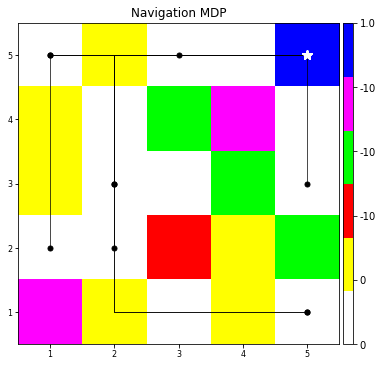

In [7]:
np.random.seed(1)
N_tau = 10
D_traj_states, D_traj_actions = nvmdp.sample_data(n_trajectory=N_tau)
nvmdp.visualize_grid(trajectories=D_traj_states, show_rewards_cbar=True)

In [8]:
gamma = 0.9999
nA = len(nvmdp.actions)
H = 3
phi = nvmdp.feature_long_at_state
phi_loc = nvmdp.feature_long_at_loc

transition_fn = nvmdp.transition_func
actions = nvmdp.actions
phi_s_dim = len(phi(nvmdp.get_random_init_state()))

SFT, heap_size = get_training_data(D_traj_states, phi, transition_fn, actions, H)
g1 = build_rhirl_graph(heap_size, nA, phi_s_dim, gamma, H)
len(g1.get_operations())

425

### Check gradients
Try to overfit the model by maximizing a Pi(s_0, a_0)

([<matplotlib.lines.Line2D at 0x1245f8390>],
 Text(0.5,1,'p(s_0,a)'),
 Text(0.5,0,'iter'),
 Text(0,0.5,'P'))

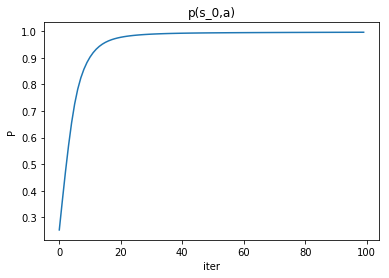

In [9]:
t_idx, s_idx = 0, 0
s, a = D_traj_states[t_idx][s_idx], D_traj_actions[t_idx][s_idx]

with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    # writer = tf.summary.FileWriter('/var/tmp/rhirl/graphs', sess.graph)
    feed_dict = {"state_feature_tree:0": SFT[s], "action_idx:0": a,
                 "learning_rate:0":0.1, "pi_init:0": np.zeros((heap_size, nA), np.float32)}
    p_vals = []
    for i in range(100):
        pi, w, grad, ugrad = sess.run(fetches=["pi_out:0", "w_r:0", "grad_w_r:0", "update_w_r"], feed_dict=feed_dict)
        p_vals.append(pi[0, a])

# writer.close()
plt.plot(p_vals), plt.title("p(s_0,a)"), plt.xlabel("iter"), plt.ylabel("P")

### RHIRL training

Total: 2265.681743621826 ms, SFT compute: 1.353384509231105 ms, Epoch time: 75.521985689799 ms


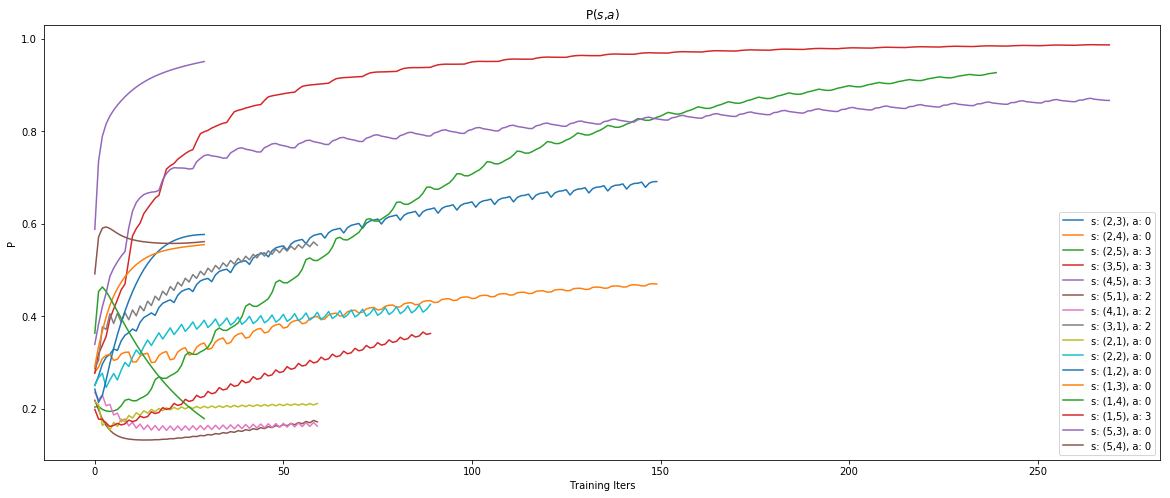

In [15]:
p_vals, w, time_state, time_epoch, time_total = rhirl_train(SFT, heap_size, nA, D_traj_states, D_traj_actions, g1, n_epochs=30, lr=0.01, verbose=False)
print("Total: {} ms, SFT compute: {} ms, Epoch time: {} ms".format(time_total, time_state, time_epoch))
plot_p_vals_all_states(p_vals, D_traj_states, D_traj_actions)

In [16]:
cell_rewards = nvmdp.compute_cell_rewards(w, phi_loc)

print("cell, true, obtained")
list(zip(["empty", "yellow", "red", "green", "purple"],[0, 0, -10, -10, -10], 
#          [round(n,2) for n in np.eye(len(nvmdp.cell_types)).dot(w)[:,0]]))
         [round(n,2) for n in np.hstack((np.eye(len(nvmdp.cell_types)), np.zeros((5,5)))).dot(w)[:,0]]))

cell, true, obtained


[('empty', 0, -0.33),
 ('yellow', 0, 0.69),
 ('red', -10, -2.29),
 ('green', -10, -5.27),
 ('purple', -10, -3.41)]

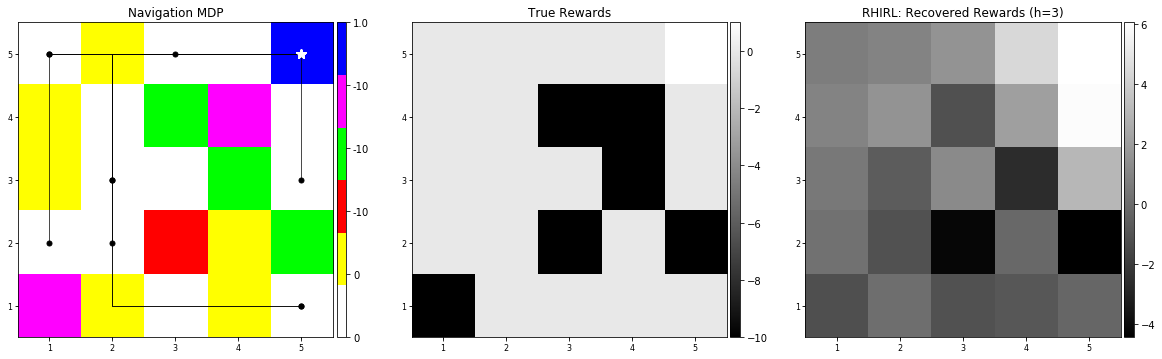

In [17]:
plt.figure(figsize=(20,12))
# cmap=colors.ListedColormap(['white','yellow','red','green','purple', 'blue'])
nvmdp.visualize_grid(nvmdp.cells, trajectories=D_traj_states, 
                     subplot_str="131", new_fig=False, show_rewards_cbar=True)
nvmdp.visualize_grid(nvmdp.cell_rewards, trajectories=None, 
               cmap=plt.cm.gray, subplot_str="132", title="True Rewards", new_fig=False)
nvmdp.visualize_grid(cell_rewards, trajectories=None, 
               cmap=plt.cm.gray, subplot_str="133", new_fig=False, title="RHIRL: Recovered Rewards (h={})".format(H))

Assumptions:
    
    - Beta (Boltzmann temperature ) is set to 1!
    - Init state is randomly sampled from the white cells.
    - Pr(Tau) is missing. But it's not in the RHIRL paper so probably this is fine but who knows. 
    - Gradient/Loss isn't validated for multiple trajectories.
    - Number of trajectories are in the order of 8-100.
    - Learning method (Adam/SGD), learning rate (1e-1 to 1e-5), and strategy used to avoid overfitting (early stopping and adam provided benefits). 
    - Features used in generating Fig 2(c), I'm using all 10 but maybe author used only distances.